In [ ]:
from torch.utils.data import Dataset
import numpy as np
from glob import glob
import torch

class CustomDataset(Dataset):
    def __init__(self, files, sequence_length, window_size=25):
        # self.folder = folder
        self.all_folders = files
        self.sequence_length = int(sequence_length)
        self.window_size = int(window_size)
        self.batch_sequence_segment = np.zeros((len(self.all_folders)), dtype=np.int)

    def __len__(self):
        return int((len(self.all_folders)))
    
    def __getitem__(self, idx):
        # if idx == 0:
        #     print(self.batch_sequence_segment[idx])
        data = np.load(self.all_folders[idx])
        inp, target, mask = torch.tensor(data['inp']), torch.tensor(data['target']), torch.tensor(data['mask'])
        inp_idx, targ_idx, mask_idx = inp[self.batch_sequence_segment[idx]:self.batch_sequence_segment[idx]+self.window_size], \
                            target[self.batch_sequence_segment[idx]:self.batch_sequence_segment[idx]+self.window_size], \
                            mask[self.batch_sequence_segment[idx]:self.batch_sequence_segment[idx]+self.window_size]
        # if self.batch_sequence_segment[idx] == inp.shape[0] - self.window_size:
        if self.batch_sequence_segment[idx] == self.sequence_length - self.window_size:
            self.batch_sequence_segment[idx] = 0
        else:
            self.batch_sequence_segment[idx] += self.window_size
        return inp_idx, targ_idx, mask_idx, self.batch_sequence_segment[idx] == 25, idx

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset

# data_file = '/common/users/dm1487/legged_manipulation_data/rollout_data/set_3_trajectories/rnn_200k_data.npz'

# data_dict = np.load(data_file)
# print(list(data_dict.keys()))

# inp = data_dict['inp']
# target = data_dict['target']
# mask = data_dict['mask'][:, :750]
# print(inp.shape, target.shape, mask.shape)

In [ ]:
# from tqdm import tqdm
# from pathlib import Path
# traj_data_file = '/common/users/dm1487/legged_manipulation_data/rollout_data/set_3_trajectories/all_trajectory_files'
# Path(traj_data_file).mkdir(parents=True, exist_ok=True)
# for idx, (i, j, k) in tqdm(enumerate(zip(inp, target, mask))):
#     np.savez_compressed(f'{traj_data_file}/{idx}', inp=i, target=j, mask=k)

In [ ]:
traj_data_file = '/common/users/dm1487/legged_manipulation_data/rollout_data/set_3_trajectories/all_trajectory_files'

train_idxs = np.concatenate((np.random.randint(0, 60000, 40000), np.random.randint(60000, 120000, 40000), np.random.randint(120000, 180000, 40000)), axis=-1).astype(int).tolist()
train_idxs = np.random.randint(0, 180000, 1000).astype(int).tolist()

# train_idxs = np.random.randint(0, 180000, 30000).astype(int).tolist()
test_idxs = np.random.randint(180000, 200000, 1000).astype(int).tolist()

training_files = sorted(glob(f'{traj_data_file}/*.npz'), key=lambda x: int(x.split('.npz')[0].split('/')[-1]))
training_files = [training_files[i] for i in train_idxs]
test_files = sorted(glob(f'{traj_data_file}/*.npz'), key=lambda x: int(x.split('.npz')[0].split('/')[-1]))
test_files = [test_files[i] for i in test_idxs]

ds = CustomDataset(files=training_files, sequence_length=250, window_size=250)
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [ ]:
# next(iter(dl))[0].shape

In [ ]:
# A 2 layer LSTM with 128 hidden units with prediction of every output
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden_states=None):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

In [ ]:
import math
class MiniTransformer(nn.Module):
    def __init__(self, input_size, output_size, embed_size=512, hidden_size=2048, num_heads=8, max_sequence_length=250, num_layers=6):
        super(MiniTransformer, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_in = nn.Linear(input_size, embed_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, 
                                                        dim_feedforward=hidden_size, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.linear_out = nn.Linear(embed_size, output_size)
        self.positonal_embedding = PositionalEncoding(embed_size, max_len=max_sequence_length)
    
    def forward(self, x, src_mask, key_mask):
        x = self.linear_in(x)
        # print(x)
        x = self.positonal_embedding(x)
        x = self.encoder(x, mask=src_mask, src_key_padding_mask=key_mask)
        # print(x)
        x = self.linear_out(x)
        return x

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
model = MiniTransformer(37, 14, 512, 2048, 8, 250, 4)

In [ ]:
src_mask = torch.triu(torch.ones(250, 250) * float('-inf'), diagonal=1)
src_mask

In [ ]:
for i, (inp, targ, mask, done, idx) in enumerate(dl):
    new_mask = torch.ones_like(mask) * float('-inf')
    new_mask[mask.nonzero(as_tuple=True)] = 0.
    out = model(inp, src_mask=src_mask, key_mask=new_mask)
    print(out.shape, targ.shape)
    break

In [60]:
from pathlib import Path
import os
import numpy as np
from tqdm import tqdm
import pickle

In [50]:
DATA_PATH_TRAJ = Path(f'/common/users/dm1487/legged_manipulation_data/rollout_data/latest_individual_traj_mini')
all_files = os.listdir(DATA_PATH_TRAJ)

In [54]:
from pathlib import Path
import os
import numpy as np
from tqdm import tqdm
import pickle
DATA_PATH_TRAJ = Path(f'/common/users/dm1487/legged_manipulation_data/rollout_data/latest_individual_traj_mini')
all_files = os.listdir(DATA_PATH_TRAJ)
ignore_files = []
for i in tqdm(all_files[:]):
    traj = np.load(DATA_PATH_TRAJ/i)
    last_idx = traj['done'].nonzero()[0][-1]
    if np.sum(traj['fsw'][last_idx][:7]) != 0:
        if np.sum(traj['fsw'][last_idx][1:7] == traj['priv_obs'][last_idx][1:7]) != 6:
            
            ignore_files.append(DATA_PATH_TRAJ/i)
            
## save ignore_files as pickle

100%|██████████████████████████████████████████████████████████████████████████████████████| 161375/161375 [10:03<00:00, 267.31it/s]


In [57]:
(len(ignore_files)/len(all_files))*100.

18.422308288148724

In [51]:
import pickle
with open('/common/users/dm1487/legged_manipulation_data/rollout_data/ignore_files_latest_individual_traj_mini.pkl', 'rb') as f:
    ignore_files_loaded = pickle.load(f)

In [52]:
len(ignore_files_loaded)

29729

In [53]:
idxs_ignored = [int(i.stem.split('_')[-1]) for i in ignore_files_loaded]

In [77]:
len(list(set(np.arange(0, len(all_files)).tolist()) - set(idxs_ignored)))

131646

## Transformer test

In [87]:
from indep_model.model import MiniTransformer
from indep_model.data import CustomDataset
import torch
from torch import nn
from pathlib import Path
from glob import glob
import numpy as np
from torch.utils.data import DataLoader
from indep_model.visualization import get_visualization, get_animation
from matplotlib import animation
from tqdm import tqdm
FFwriter = animation.FFMpegWriter

In [80]:

len(all_train_test_files)

265951

103427


In [95]:
model = MiniTransformer(input_size=37, output_size=14, embed_size=128, hidden_size=2048, num_heads=8, max_sequence_length=250, num_layers=8)
model = model.to('cuda:0')
model.load_state_dict(torch.load('../indep_model/results/transformer_250_2048/2023-01-30_18-59-39/checkpoints/model_50.pt'))
model.eval()
print()

In [ ]:
traj_data_file = '/common/users/dm1487/legged_manipulation_data/rollout_data/latest_individual_traj_1'
all_train_test_files = sorted(glob(f'{traj_data_file}/*.npz'), key=lambda x: int(x.split('.npz')[0].split('/')[-1].split('_')[-1]))
idxs = np.random.randint(0, len(all_train_test_files), 100).astype(int)
for n_idx in tqdm(idxs):
    traj = np.load(all_train_test_files[n_idx])
    one = CustomDataset(files=[all_train_test_files[n_idx]], sequence_length=250, window_size=250)
    inp, targ, mask, fsw, done, idx = next(iter(DataLoader(one)))
    inp, targ, mask, fsw =  inp.to('cuda:0'), targ.to('cuda:0'), mask.to('cuda:0'), fsw.to('cuda:0')
    src_mask = torch.triu(torch.ones(250, 250) * float('-inf'), diagonal=1).to('cuda:0')
    patches = []
    with torch.inference_mode():
        for i in range(1, inp.shape[1]+1):
            new_inp = torch.nn.functional.pad(inp[:, :i, :], (0, 0, 0, 250-i))
            out = model(new_inp, src_mask)
            patches.append(get_visualization(0, inp[:, i-1, :], targ[:, i-1, :], out[:, i-1, :], fsw[:, i-1, :]))
        anim = get_animation(patches[:(mask[idx, :, :].nonzero()[:, 1][-1])])
        anim.save(f'../indep_model/psuedo_online_sim_results/{n_idx.item()}.mp4', writer = FFwriter(5))

In [268]:
dof = torch.load('/common/users/dm1487/abc_3/dof_vel_tracker.zip').permute(1, 0)[:-1]
tau = torch.load('/common/users/dm1487/abc_3/est_tau_tracker.zip').permute(1, 0)[:-1]
obs = torch.load('/common/users/dm1487/abc_3/observation_tracker.zip').permute(1, 0)
obs.shape, tau.shape, dof.shape

(torch.Size([2370, 13]), torch.Size([2370, 12]), torch.Size([2370, 12]))

torch.Size([250, 37])
torch.Size([1, 250, 13])


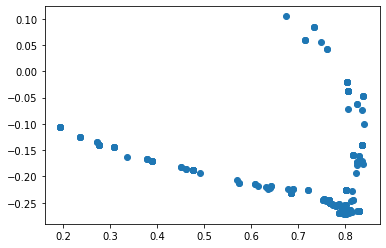

In [276]:
# from matplotlib import pyplot as plt
# 
traj_all = torch.cat([obs, tau, dof], dim=-1)[700:-100][::6][:250]
print(traj_all.shape)

obs_1 = obs[700:-100][::6][:250].unsqueeze(0)
print(obs_1.shape)
plt.scatter(obs_1[0, :, 0],  obs_1[0, :, 1])

In [277]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [278]:
count_parameters(model)

5343886

In [279]:
traj_all_2 = traj_all.view(-1, *traj_all.shape)
# traj_all_2.shape

In [280]:
traj_all_2 = torch.nn.functional.pad(traj_all_2, (0, 0, 0, 250-traj_all_2.shape[1]))

In [281]:
# one = CustomDataset(files=[all_train_test_files[n_idx]], sequence_length=250, window_size=250)
# inp, targ, mask, fsw, done, idx = next(iter(DataLoader(one)))
# inp, targ, mask, fsw =  inp.to('cuda:0'), targ.to('cuda:0'), mask.to('cuda:0'), fsw.to('cuda:0')
traj_all_1 = traj_all_2.to('cuda:0')
src_mask = torch.triu(torch.ones(250, 250) * float('-inf'), diagonal=1).to('cuda:0')
patches = []
with torch.inference_mode():
    out = model(traj_all_1, src_mask)
# with torch.inference_mode():
#     for i in range(1, inp.shape[1]+1):
#         print(i)
#         new_inp = torch.nn.functional.pad(traj_all_1[:, :i, :], (0, 0, 0, 250-i))
#         out = model(new_inp, src_mask)
#         patches.append(get_visualization(0, traj_all_1[:, i-1, :], targ[:, i-1, :], out[:, i-1, :], fsw[:, i-1, :]))
#     anim = get_animation(patches[:(mask[idx, :, :].nonzero()[:, 1][-1])])
for i in range(1, traj_all_1.shape[1]+1):
    patches.append(get_visualization(0, obs_1[:, i-1, :], fsw[:, i-1, :], out[:, i-1, :], fsw[:, i-1, :]))
anim = get_animation(patches)

In [282]:
anim.save(f'test.mp4', writer = FFwriter(5))